In [1]:
import os
user_directory = os.path.join(os.path.expanduser('~'), '')
os.chdir(user_directory)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

# Override the default linewidth and markersize
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

from datetime import datetime
import utils

In [3]:
ROOT_DIR = './Downloads/'
TARGET_TEST_CUTOFF_DATE = '01-01-2016'

In [4]:
df = pd.read_csv(ROOT_DIR + 'PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [5]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<Figure size 2250x1500 with 0 Axes>

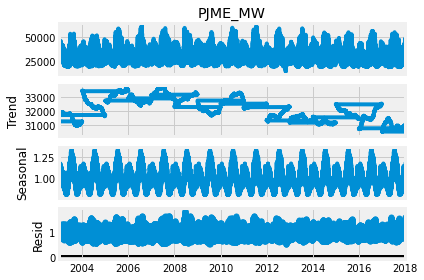

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the period for annual decomposition
ANNUAL_PERIOD = 365 * 24

# Perform seasonal decomposition
mult_decomp = seasonal_decompose(df['PJME_MW'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)

# Set up the figure size and resolution
fig = plt.figure(figsize=(15, 10), dpi=150)

# Plot the decomposition
mult_decomp.plot()
plt.show()


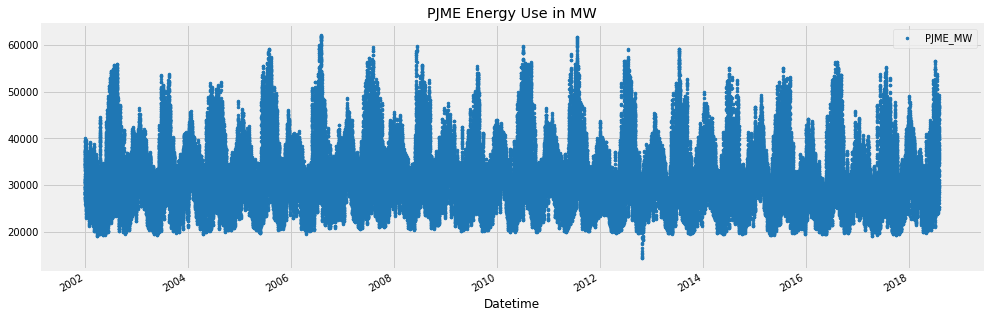

In [7]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [8]:
train = df.loc[df.index < TARGET_TEST_CUTOFF_DATE]
test = df.loc[df.index >= TARGET_TEST_CUTOFF_DATE]

## Plot the Train and Test Split data

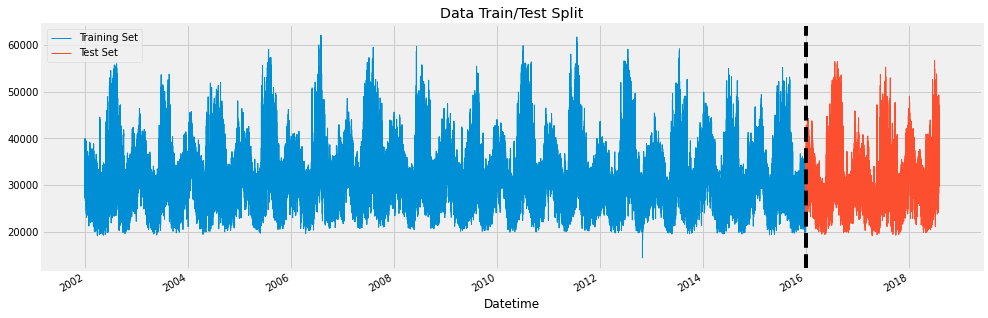

In [9]:
utils.plot_train_test_split(df, TARGET_TEST_CUTOFF_DATE)

## Sample Weekly Data

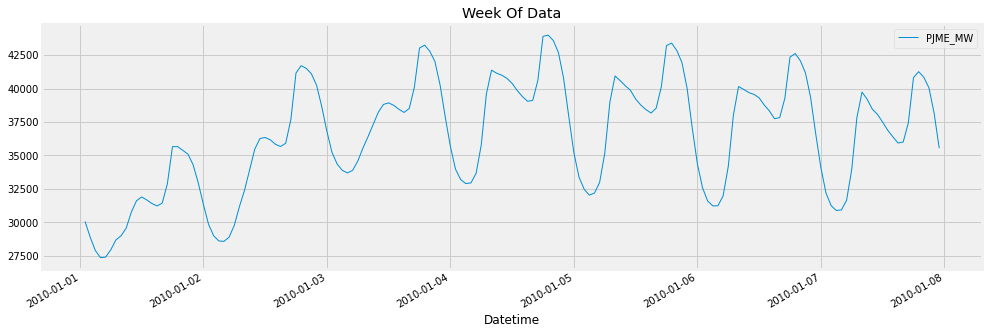

In [10]:
utils.plot_week_of_data(df, '01-01-2010', '01-08-2010')

## Create and Visualize Feature / Target Relationship

In [11]:
df = utils.create_time_series_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


/var/folders/t0/stwxxjg52m31k16c4hqwxk2w0000gn/T/ipykernel_54499/2831589874.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(dow_labels)


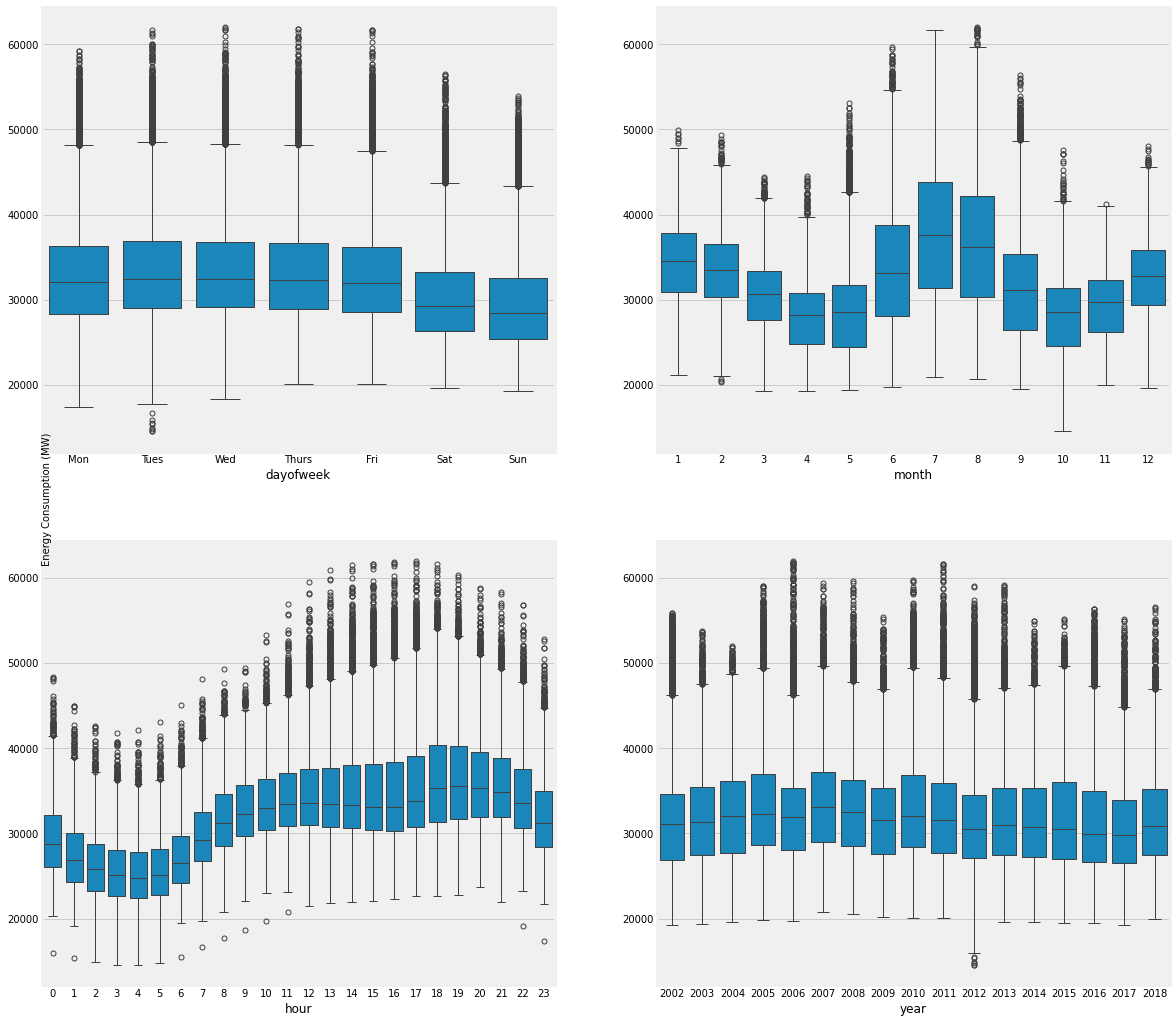

In [12]:
def plot_time_series(df, dependent_var):
    """
    This function generates a 2x2 grid of boxplots to visualize the time series data.
    ( this function assumes that the input dataframe has columns named dayofweek, month, hour, and year. If your dataframe uses different column names for these time-related variables, you should modify the function accordingly.)
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the time series data.
        
    dependent_var : str
        The column name of the dependent variable in the dataframe.
        
    Returns
    -------
    None
    """
    
    # Assert if the required columns are present in the dataframe
    assert 'dayofweek' in df.columns, "Input dataframe must have a 'dayofweek' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert 'hour' in df.columns, "Input dataframe must have an 'hour' column"
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"
    """ this function assumes that the input dataframe has columns named dayofweek, month, hour, and year. If your dataframe uses different column names for these time-related variables, you should modify the function accordingly. """
    
    # Initialize the figure with a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(18,18))
    
    # Day of Week
    dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    g = sns.boxplot(x=df.dayofweek, y=df[dependent_var], ax=axes[0][0])
    g.set_xticklabels(dow_labels)
    g.set_ylabel('')
    
    # Month of Year
    g = sns.boxplot(x=df.month, y=df[dependent_var], ax=axes[0][1])
    g.set_ylabel('')
    
    # Hour of Day
    g = sns.boxplot(x=df.hour, y=df[dependent_var], ax=axes[1][0])
    g.set_ylabel('')
    
    # Year
    g = sns.boxplot(x=df.year, y=df[dependent_var], ax=axes[1][1])
    g.set_ylabel('')
    
    # Set the title for the y-axis
    fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
    
    # Display the plot
    plt.show()

plot_time_series(df, 'PJME_MW')

In [13]:
df_dup = df.copy()
years_months = df_dup.groupby(['year', 'month']).mean().reset_index()
years_months.head()

,year,month,PJME_MW,hour,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,2002,1,31075.399731,11.515478,2.905787,1.0,16.020188,16.020188,2.873486
1,2002,2,30239.166667,11.500000,3.000000,1.0,45.500000,14.500000,7.071429
2,2002,3,28875.256720,11.500000,3.193548,1.0,75.000000,16.000000,11.258065
3,2002,4,28534.731572,11.511822,2.828929,2.0,105.511822,15.511822,15.668985
4,2002,5,28073.653226,11.500000,3.000000,2.0,136.000000,16.000000,20.0


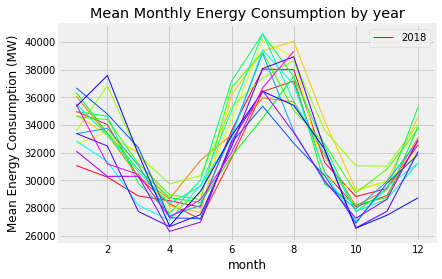

In [14]:
import matplotlib.pyplot as plt

def plot_monthly_consumption(df, dependent_var):
    """
    This function generates a line plot of the mean monthly energy consumption for each year.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the time series data.
        
    dependent_var : str
        The column name of the dependent variable in the dataframe.
        
    Returns
    -------
    None
    """
    
    
    # Assert if the required columns are present in the dataframe
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"
    """ Please note that this function assumes that the input dataframe has columns named year and month, and the column representing the dependent variable (in this case, 'PJME_MW'). If your dataframe uses different column names for these variables, you should modify the function accordingly. """

    df_copy = df.copy()

    # Group data by year and month, and compute the mean for each group
    year_group = df_copy.groupby(['year', 'month']).mean().reset_index()
    
    # Get the unique years from the dataframe
    years = df_copy['year'].unique()
    NUM_COLORS = len(years)

    # Prepare color mapping
    cm = plt.get_cmap('gist_rainbow')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    # Plot the mean monthly consumption for each year
    for i, y in enumerate(years):
        df_copy = year_group[year_group['year'] == y]
        plt.plot(df_copy['month'], df_copy[dependent_var], linewidth=1, markersize=5)
    
    plt.title('Mean Monthly Energy Consumption by year')
    plt.xlabel('month')
    plt.ylabel('Mean Energy Consumption (MW)')
    plt.legend(df_copy.year.unique())
    plt.show()

plot_monthly_consumption(df, 'PJME_MW')

In [15]:
train = utils.create_time_series_features(train)
test = utils.create_time_series_features(test)
train.head(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1


In [16]:
train['weekofyear'] = train['weekofyear'].astype('int32')
test['weekofyear'] = test['weekofyear'].astype('int32')

In [17]:
time_series_features = ['dayofyear', 'hour', 'dayofweek', 'weekofyear', 'quarter', 'month', 'year']
time_series_target = 'PJME_MW'

X_train = train[time_series_features]
y_train = train[time_series_target]

X_test = test[time_series_features]
y_test = test[time_series_target]

In [18]:
X_train.head(2)

,dayofyear,hour,dayofweek,weekofyear,quarter,month,year
Datetime,,,,,,,
2002-12-31 01:00:00,365,1,1,1,4,12,2002
2002-12-31 02:00:00,365,2,1,1,4,12,2002


In [19]:
y_test.head(2)

Datetime
2016-01-01 00:00:00    26686.0
2016-12-31 01:00:00    29627.0
Name: PJME_MW, dtype: float64

In [20]:
model = utils.train_xgb_regressor(X_train, y_train, X_test, y_test, use_gpu=True)

GPU support is not available on Mac M1. Switching to CPU.
[0]	validation_0-rmse:32564.68916	validation_1-rmse:31496.82797


/Users/erfanseifi/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:25:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12383.11219	validation_1-rmse:11551.15715
[200]	validation_0-rmse:5403.45381	validation_1-rmse:5195.67995
[300]	validation_0-rmse:3370.22353	validation_1-rmse:3975.08700
[400]	validation_0-rmse:2884.41122	validation_1-rmse:3932.76320
[406]	validation_0-rmse:2871.45119	validation_1-rmse:3935.40101


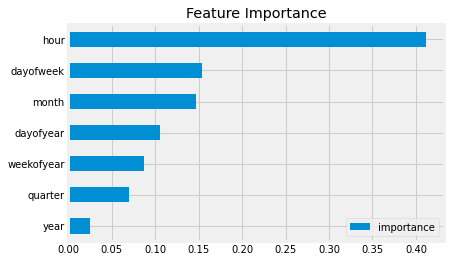

In [21]:
utils.plot_feature_importance(model)

In [22]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df.tail(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36337.640625
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,32604.587891


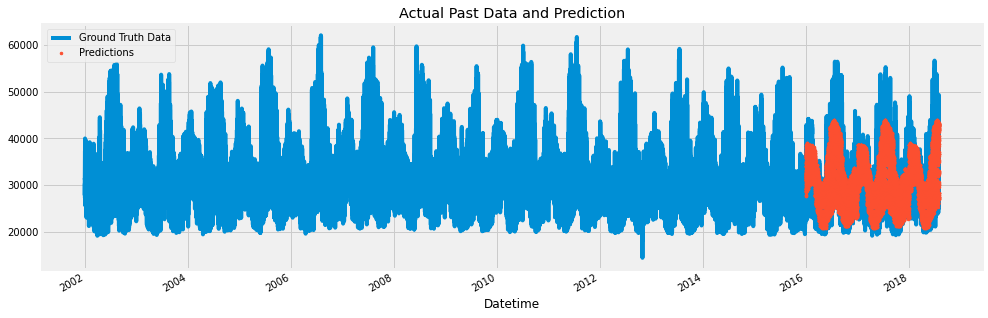

In [23]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()

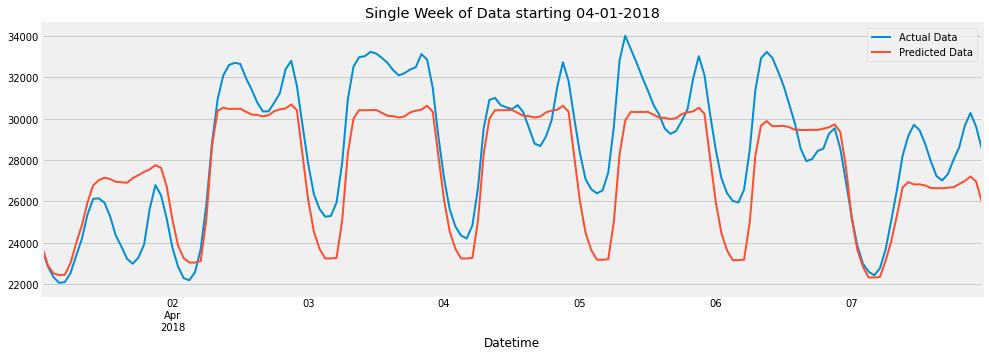

In [24]:
# select data within a specific date range
data = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]

# plot the actual and predicted data
ax = data['PJME_MW'].plot(figsize=(15, 5), title='Single Week of Data starting 04-01-2018', linewidth=2, markersize=5)

data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

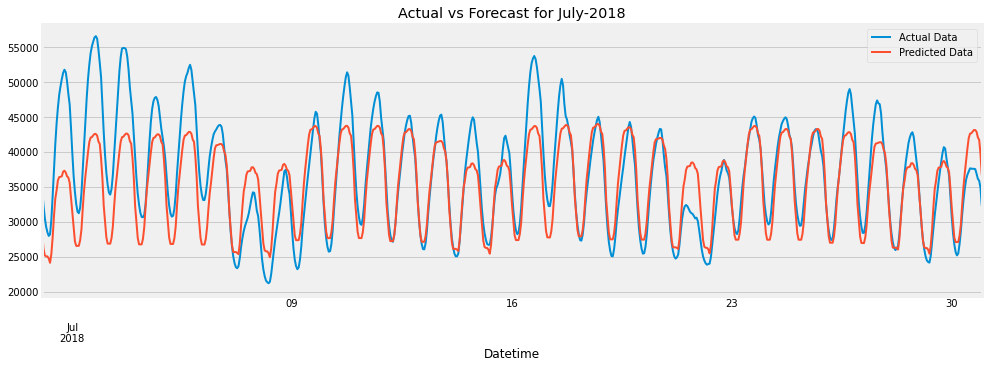

In [25]:
# select data within a specific date range
data = df.loc[(df.index > '07-01-2018') & (df.index < '07-31-2018')]

# plot the actual portion
ax = data['PJME_MW'].plot(figsize=(15, 5), title='Actual vs Forecast for July-2018', linewidth=2, markersize=5)

# plot the predicted portion
data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

In [26]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3915.11


## Sort Predictions by Error values

In [27]:
test['error'] = np.abs(test[time_series_target] - test['prediction'])

test['date'] = test.index.date

test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13173.750570
2016-08-14    12671.718343
2017-12-31    12233.581380
2016-09-10    11610.771647
2017-12-28    11473.280436
2017-12-29    11358.851725
2018-01-06    11017.410889
2016-08-12    10800.534017
2016-12-16    10725.715902
2016-09-09    10339.877279
Name: error, dtype: float64